# 2D 

## Calcules et repésentaions `simulation_gaz_2d.py`

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe : système de particules
# ================================================================
import numpy as np

class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.01, T=0.12, max_init_attempts=5000):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T
        self.max_init_attempts = max_init_attempts

        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))
        self.history_positions = []
        self.history_velocities = []

    # ==============================================================
    # 🔹 Initialisation des positions sans recouvrement
    # ==============================================================
    def init_positions(self, mode="uniform", center_position=None, min_dist_center=None):
        positions = []
        min_dist = 2 * self.ball_radius

        for n in range(self.num_balls):
            for attempt in range(self.max_init_attempts):
                if mode == "uniform":
                    candidate = np.random.rand(2) * self.box_size
                elif mode == "double_gaussian":
                    if n < self.num_balls // 2:
                        candidate = np.random.normal([1.5, 2.5], [0.3, 0.3])
                    else:
                        candidate = np.random.normal([3.5, 2.5], [0.3, 0.3])
                elif mode == "centered":
                    # On place la première boule à la position choisie
                    if n == 0:
                        if center_position is None:
                            raise ValueError("center_position doit être spécifiée en mode 'centered'")
                        candidate = np.array(center_position)
                    else:
                        candidate = np.random.rand(2) * self.box_size

                        # On force la distance minimale avec la boule 1
                        if min_dist_center is None:
                            raise ValueError("min_dist_center doit être spécifiée en mode 'centered'")
                        if np.linalg.norm(candidate - positions[0]) < min_dist_center:
                            continue  # trop proche du centre → on recommence
                        
                else:
                    raise ValueError(f"Mode inconnu : {mode}")

                # Vérifie la distance avec toutes les particules déjà placées
                if all(np.linalg.norm(candidate - p) >= min_dist for p in positions):
                    positions.append(candidate)
                    break
            else:
                raise RuntimeError(f"Impossible de placer la particule {n} sans chevauchement après {self.max_init_attempts} essais")

        self.positions = np.array(positions)

    # ==============================================================
    # 🔹 Initialisation des vitesses
    # ==============================================================
    def init_velocities(self, mode="double_gaussian"):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T)
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mu = 0.5
            sigma = mu/10
            self.velocities[:half] = np.random.normal([-mu, -mu], [sigma, sigma], (half, 2))
            self.velocities[half:] = np.random.normal([mu, mu], [sigma, sigma], (self.num_balls - half, 2))
        elif mode == "pichnette":
            # Toutes les vitesses à zéro
            self.velocities = np.zeros((self.num_balls, 2))
            
            # Choisir une balle (par exemple la première) à laquelle on donne une vitesse
            idx = 0  # ou np.random.randint(self.num_balls) pour aléatoire
            v0 = 10.0  # norme de la vitesse initiale
            angle = np.pi*0#np.random.uniform(0, 2 * np.pi)
            self.velocities[idx] = [v0 * np.cos(angle), v0 * np.sin(angle)]
        else:
            raise ValueError(f"Mode inconnu : {mode}")

    # ==============================================================
    # 🔹 Mise à jour avec correction d'interpénétration
    # ==============================================================
    def update(self):
        """Mise à jour du système à chaque pas de temps."""
        self.positions += self.velocities * self.dt
        self.positions %= self.box_size  # bords périodiques
        self._handle_collisions()
        self.history_positions.append(np.copy(self.positions))
        self.history_velocities.append(np.copy(self.velocities))

    # ==============================================================
    # 🔹 Collisions élastiques avec correction géométrique
    # ==============================================================
    def _handle_collisions(self):
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)

                if dist < 2 * self.ball_radius and dist > 0:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    v_rel = np.dot(dv, direction)

                    # Collision seulement si les particules se rapprochent
                    if v_rel < 0:
                        impulse = v_rel * direction
                        self.velocities[i] -= impulse
                        self.velocities[j] += impulse

                        # Correction géométrique : repositionner les particules sans recouvrement
                        overlap = 2 * self.ball_radius - dist
                        correction = direction * (overlap / 2)
                        self.positions[i] += correction
                        self.positions[j] -= correction



# ================================================================
# 🔹 2. Classe : sauvegarde & chargement des données
# ================================================================
class SimulationRecorder:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def save_data(self):
        """Sauvegarde toutes les données de la simulation."""
        np.savez(
            os.path.join(self.output_dir, "2D_simulation_data.npz"),
            positions=np.array(self.system.history_positions),
            velocities=np.array(self.system.history_velocities)
        )
        with open(os.path.join(self.output_dir, "2D_params.json"), "w") as f:
            json.dump({
                "num_balls": self.system.num_balls,
                "box_size": self.system.box_size,
                "ball_radius": self.system.ball_radius,
                "dt": self.system.dt,
                "T": self.system.T
            }, f, indent=4)
        print("✅ Données sauvegardées dans", self.output_dir)

    @staticmethod
    def load_data(input_dir="outputs"):
        """Charge les données enregistrées pour rejouer ou analyser."""
        data = np.load(os.path.join(input_dir, "2D_simulation_data.npz"))
        with open(os.path.join(input_dir, "2D_params.json")) as f:
            params = json.load(f)
        return data, params


# ================================================================
# 🔹 3. Classe : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, positions, velocities):
        self.positions = positions
        self.velocities = velocities

    def compute_moments(self, order=2):
        v = np.linalg.norm(self.velocities, axis=2)
        return np.mean(v**order, axis=1)

    def animate_moments(self, output_dir="outputs", fps=20 ):
        fig, ax = plt.subplots()
        orders = [0, 1, 2, 3]
        lines = [ax.plot([], [], label=f"Ordre {n}")[0] for n in orders]
        ax.set_xlim(0, len(self.positions))
        ax.set_ylim(0, None)
        ax.legend()
        ax.set_title("Évolution des moments selon le temps")

        moments = [self.compute_moments(order=n) for n in orders]

        #print(moments)

        def update(frame):
            for n, line in enumerate(lines):
                line.set_data(np.arange(frame), moments[n][:frame])
            return lines

        ani = FuncAnimation(fig, update, frames=len(self.positions), blit=True, interval=100)
        ani.save(os.path.join(output_dir, "moments_evolution.mp4"), writer="ffmpeg", fps=fps)
        plt.close(fig)
        print("🎞️ Animation moments enregistrée.")


class VelocityAnalyzer:
    def __init__(self, system, output_dir="output"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    # ================================================================
    # 🔹 CORRELATION D'ORDRE n
    # ================================================================
    def animate_correlation(self, order=2, fps=24):
        """
        Anime les corrélations d'ordre n des vitesses vx et vy.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vxs = history[frame][:, 0]
            vys = history[frame][:, 1]

            # Corrélations d'ordre n (brute, sans centrage)
            Cx = np.outer(vxs, vxs)**(order//2)
            Cy = np.outer(vys, vys)**(order//2)

            # Moyenne sur la diagonale
            diag_x = np.diag(Cx)
            diag_y = np.diag(Cy)
            diag_mean = 0.5*(np.mean(diag_x) + np.mean(diag_y))

            if order <= 2:
                im = ax.imshow(Cx, cmap='viridis', origin='lower')
                #if frame == 0 : plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$C^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='goldenrod', label=r"$C_x$")
                ax.plot(np.arange(N), diag_y, color='royalblue', label=r"$C_y$")
                ax.set_title(rf"Corrélation diagonale d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$C_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"2D_correlation_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Corrélation d'ordre {order} enregistrée : {output_path}")


    # ================================================================
    # 🔹 CUMULANT D'ORDRE n
    # ================================================================
    def animate_cumulant(self, order=2, fps=24):
        """
        Anime les cumulants d'ordre n des vitesses vx et vy.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vxs = history[frame][:, 0]
            vys = history[frame][:, 1]

            # Centrage des vitesses
            dvx = vxs - np.mean(vxs)
            dvy = vys - np.mean(vys)

            # Cumulants d'ordre n
            Kx = np.outer(dvx, dvx)**(order//2)
            Ky = np.outer(dvy, dvy)**(order//2)

            diag_x = np.diag(Kx)
            diag_y = np.diag(Ky)

            if order <= 2:
                im = ax.imshow(Kx, cmap='plasma', origin='lower')
                #if frame == 0 :  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$K^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='darkorange', label=r"$K_x$")
                ax.plot(np.arange(N), diag_y, color='navy', label=r"$K_y$")
                ax.set_title(rf"Cumulant diagonal d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$K_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"2D_cumulant_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Cumulant d'ordre {order} enregistré : {output_path}")

# ================================================================
# 🔹 4. Classe : animation visuelle
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="mp4", show_grid=True):
        fig, ax = plt.subplots()
        ax.set_xlim(self.system.ball_radius, self.system.box_size - self.system.ball_radius)
        ax.set_ylim(self.system.ball_radius, self.system.box_size - self.system.ball_radius)
        ax.set_xticks([]); ax.set_yticks([])

        # Ajout de la grille manuelle
        if show_grid:
            for i in range(1, int(self.system.box_size)):
                ax.plot([i, i], [0, self.system.box_size], color='gray', linestyle='--', lw=0.5)
                ax.plot([0, self.system.box_size], [i, i], color='gray', linestyle='--', lw=0.5)

        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 100)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)
        path = os.path.join(self.output_dir, f"2D_positions_animation.{fmt}")
        ani.save(path, writer="ffmpeg", fps=fps, dpi=200)
        plt.close(fig)
        print("🎞️ Animation positions enregistrée :", path)

    

    def animate_2D_velocity_distribution(self, fps=24):
        

        # parametres gaussienne thermalisation
        vxs = self.system.history_velocities[0][:, 0]
        vys = self.system.history_velocities[0][:, 1]

        # --- Calcul des moyennes et écarts-types ---
        mean_vx, mean_vy = np.mean(vxs), np.mean(vys)
        sigma_vx, sigma_vy = np.std(vxs), np.std(vys)

        mean_v = np.mean([mean_vx, mean_vy])
        sigma_v = np.std(np.concatenate((vxs, vys)))


        mean_vx, mean_vy = mean_v , mean_v
        sigma_vx, sigma_vy = sigma_v , sigma_v

        # --- Calculer les gaussiennes correspondantes ---
        def gaussian(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)

        vmax = int(max([mean_vx + 3*sigma_vx , mean_vy + 3*sigma_vy]))+1 
        pmax = max([gaussian(0, mean_vx, sigma_vx) , gaussian(0, mean_vy, sigma_vy)  ]) + 0.005 

        
        v = np.linspace(-vmax, vmax, 300)
        vx_therm , vy_therm = gaussian(v, mean_vx, sigma_vx), gaussian(v, mean_vy, sigma_vy)



        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        ax.set_xlabel(r"Vitesse $v_x, v_y$", fontsize=12)
        ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
        ax.set_title(r"Distribution normalisée des vitesses $v_x$ et $v_y$", fontsize=14)
        
        # Initialisation vide
        bins = np.linspace(-vmax, vmax, 30)
        hist_vx = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=r"$v_x$")
        hist_vy = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='royalblue', alpha=0.4, label=r"$v_y$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vxs = self.system.history_velocities[frame][:, 0]
            vys = self.system.history_velocities[frame][:, 1]
            
            # Histogrammes normalisés
            ax.hist(vxs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=r"$v_x$")
            ax.hist(vys, bins=bins, density=True, color='royalblue', alpha=0.4, label=r"$v_y$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, vx_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            ax.plot(v, vy_therm, color='royalblue', lw=2, linestyle='--', alpha=1)#, label=rf"Gaussienne $v_y$ ($\mu$={mean_vy:.2f}, $\sigma$={sigma_vy:.2f})")


            # --- Habillage graphique ---
            ax.set_xlim(-vmax, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(r"Vitesse $v_x, v_y$", fontsize=12)
            ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
            ax.set_title(rf"Distribution normalisée des vitesses — frame {frame}", fontsize=14)
            #ax.set_title(rf"Thermalisation des vitesses — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, "2D_velocity_distribution.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses enregistrée dans {output_path}.")


    def animate_moment_ordre_n_distribution(self, fps=24 , ordre = 2 ):
        

        # parametres gaussienne thermalisation
        vxs = self.system.history_velocities[0][:, 0]
        vys = self.system.history_velocities[0][:, 1]

        # --- Calcul des moyennes et écarts-types ---
        mean_vx, mean_vy = np.mean(vxs), np.mean(vys)
        sigma_vx, sigma_vy = np.std(vxs), np.std(vys)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian_X(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)       

        def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma) 

        vmax = int(max([(mean_vx + 3*sigma_vx)**ordre , (mean_vy + 3*sigma_vy)**ordre]))+1 
        
        
        if ordre % 2 == 1 :  
            vmax_min  = -vmax
            if ordre == 1 :
                pmax = max([gaussian_X(0, mean_vx, sigma_vx) , gaussian_X(0, mean_vy, sigma_vy)  ]) + 0.005 
            else :
                pmax = 1 #max([gaussian_Y(0.000001, mean_vx, sigma_vx) , gaussian_Y(0.000001, mean_vy, sigma_vy)  ]) + 0.005 
        else : 
            vmax_min  = 0
            pmax = 1 #max([gaussian_Y(0.1, mean_vx, sigma_vx) , gaussian_Y(0.1, mean_vy, sigma_vy)  ]) + 0.005 
            
        v = np.linspace(vmax_min, vmax, 300)
        vx_therm , vy_therm = gaussian_Y(v, mean_vx, sigma_vx), gaussian_Y(v, mean_vy, sigma_vy)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(vmax_min, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        
        # Initialisation vide
        bins = np.linspace(vmax_min, vmax, int(30*ordre))
        hist_vx = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=rf"$v_x^{ordre}$")
        hist_vy = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='royalblue', alpha=0.4, label=rf"$v_y^{ordre}$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vxs = self.system.history_velocities[frame][:, 0]
            vys = self.system.history_velocities[frame][:, 1]
            
            # Histogrammes normalisés
            ax.hist(vxs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=rf"$v_x^{ordre}$")
            ax.hist(vys, bins=bins, density=True, color='royalblue', alpha=0.4, label=rf"$v_y^{ordre}$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, vx_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            ax.plot(v, vy_therm, color='royalblue', lw=2, linestyle='--', alpha=1)#, label=rf"Gaussienne $v_y$ ($\mu$={mean_vy:.2f}, $\sigma$={sigma_vy:.2f})")


            # --- Habillage graphique ---
            ax.set_xlim(vmax_min, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(rf"$v_x^{ordre}, v_y^{ordre}$", fontsize=12)
            ax.set_ylabel(rf"Densité de probabilité $P(v^{ordre})$", fontsize=12)
            ax.set_title(rf"Distribution normalisée des vitesses$^{ordre}$ — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, f"2D_velocity_distribution_order_{ordre}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses order : {ordre} enregistrée dans {output_path}.")



# ================================================================
# 🔹 5. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=150, box_size=5, ball_radius=0.10, dt=0.01, T=20)
    system.init_positions("centered", center_position=(1,2), min_dist_center=0.5)#"centered"#uniform
    system.init_velocities("pichnette")#puchette#double_gaussian

    anim = AnimationManager(system)
    anim.animate_positions(n_frames=600, fps=60, fmt="mp4" , show_grid=True )
    anim.animate_2D_velocity_distribution(fps=60)
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 1 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 2 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 3 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 4 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 5 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 6 )

    #recorder = SimulationRecorder(system)
    #recorder.save_data()

    #data, _ = SimulationRecorder.load_data()
    #analysis = PhysicalAnalysis(data["positions"], data["velocities"])
    #analysis.animate_moments()
    ### Correlation et Cummulante a finie 
    #analyzer = VelocityAnalyzer(system, output_dir="animations")
    #analyzer.animate_correlation(order=2)
    #analyzer.animate_cumulant(order=2)



🎞️ Animation positions enregistrée : outputs/2D_positions_animation.mp4
🎞️ Animation des distributions de vitesses enregistrée dans outputs/2D_velocity_distribution.mp4.


## Visualiser Donner 

In [ ]:
import numpy as np

# Charger le fichier
data = np.load('./outputs/2D_simulation_data.npz')

# Afficher la liste des tableaux contenus dans le fichier
print("Clés disponibles :", data.files)

# Afficher le contenu de chaque tableau
for key in data.files:
    print(f"\n--- {key} ---")
    print(data[key])
    print("Shape :", data[key].shape)


## probabilié X^N

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Paramètres ---
mu, sigma = 0, 1
N = 3
size = 10_0000

# --- Simulation ---
x = np.random.normal(mu, sigma, size)
y = x**N

# --- Tracé ---
plt.figure(figsize=(6,4))
plt.hist(y, bins=100, density=True, color="goldenrod", alpha=0.6, label=fr"$Y = X^{N}$, N={N}")
plt.xlabel(r"$Y$")
plt.ylabel(r"$P(Y)$")
plt.title(fr"Distribution de $Y = X^{N}$ pour $X \sim \mathcal{{N}}(0,1)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/480240263.py:16: RuntimeWarning: invalid value encountered in power
  pY = norm.pdf(np.power(y, 1/N), mu, sigma) / (N * np.abs(y)**(1 - 1/N))


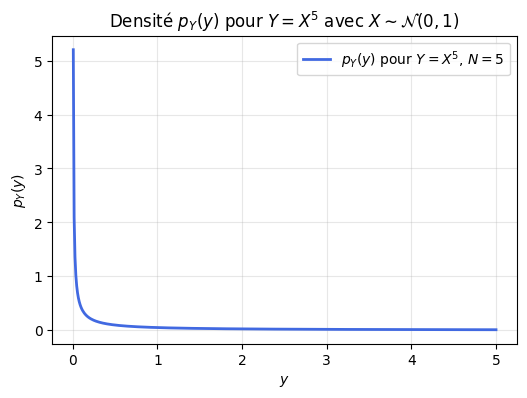

∫p_Y(y) dy = nan


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/480240263.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pY, y)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def pdf_power_normal(y, N, mu=0, sigma=1):
    """Renvoie la densité pY(y) pour Y = X^N, avec X ~ N(mu, sigma^2)."""
    y = np.array(y)
    px_pos = norm.pdf(np.power(np.abs(y), 1/N), mu, sigma)
    
    if N % 2 == 0:  # N pair → y > 0
        pY = np.zeros_like(y)
        mask = y > 0
        pY[mask] = (norm.pdf(np.power(y[mask], 1/N), mu, sigma)
                   + norm.pdf(-np.power(y[mask], 1/N), mu, sigma)) / (N * np.power(y[mask], 1 - 1/N))
    else:  # N impair
        pY = norm.pdf(np.power(y, 1/N), mu, sigma) / (N * np.abs(y)**(1 - 1/N))
    
    return pY

# --- Test ---
mu, sigma = 0, 1
N = 5
y = np.linspace(-5, 5, 1000)
pY = pdf_power_normal(y, N, mu, sigma)

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(y, pY, color='royalblue', lw=2, label=fr"$p_Y(y)$ pour $Y=X^{N}$, $N={N}$")
plt.xlabel(r"$y$")
plt.ylabel(r"$p_Y(y)$")
plt.title(fr"Densité $p_Y(y)$ pour $Y = X^{N}$ avec $X \sim \mathcal{{N}}(0,1)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Vérif de la normalisation ---
area = np.trapz(pY, y)
print("∫p_Y(y) dy =", area)


# 1D 

## Calcules et repésentaions `simulation_gaz_1d.py`

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe : système de particules
# ================================================================
import numpy as np

class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.01, T=0.12, max_init_attempts=5000):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T
        self.max_init_attempts = max_init_attempts

        self.positions = np.zeros((num_balls, 1))
        self.velocities = np.zeros((num_balls, 1))
        self.history_positions = []
        self.history_velocities = []

    # ==============================================================
    # 🔹 Initialisation des positions sans recouvrement
    # ==============================================================
    def init_positions(self, mode="uniform",center_position=None, min_dist_center=None):
        positions = []
        min_dist = 2 * self.ball_radius

        for n in range(self.num_balls):
            for attempt in range(self.max_init_attempts):
                if mode == "uniform":
                    candidate = np.random.rand(1) * self.box_size
                elif mode == "double_gaussian":
                    if n < self.num_balls // 2:
                        candidate = np.random.normal(1.5, 0.3)
                    else:
                        candidate = np.random.normal(3.5, 0.3)
                elif mode == "centered":
                    # Première particule à la position choisie
                    if n == 0:
                        if center_position is None:
                            raise ValueError("center_position doit être spécifiée en mode 'centered'")
                        candidate = np.array([center_position])
                    else:
                        candidate = np.random.rand(1) * self.box_size

                        # Vérifie la distance avec la particule 1
                        if min_dist_center is None:
                            raise ValueError("min_dist_center doit être spécifiée en mode 'centered'")
                        if abs(candidate - positions[0]) < min_dist_center:
                            continue  # trop proche de la boule 1 → on recommence
                else:
                    raise ValueError(f"Mode inconnu : {mode}")

                # Vérifie la distance avec toutes les particules déjà placées
                if all(np.linalg.norm(candidate - p) >= min_dist for p in positions):
                    positions.append(candidate)
                    break
            else:
                raise RuntimeError(f"Impossible de placer la particule {n} sans chevauchement après {self.max_init_attempts} essais")

        self.positions = np.array(positions)

    # ==============================================================
    # 🔹 Initialisation des vitesses
    # ==============================================================
    def init_velocities(self, mode="double_gaussian"):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 1))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T)
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 1))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mu = 1
            sigma = 1
            self.velocities[:half] = np.random.normal(-mu, sigma, (half, 1))
            self.velocities[half:] = np.random.normal(mu, sigma, (self.num_balls - half, 1))
        elif mode == "pichnette":
            # Toutes les vitesses à zéro
            self.velocities = np.zeros((self.num_balls, 1))
            
            # Choisir une particule (par exemple la première)
            idx = 0  # ou np.random.randint(self.num_balls) pour un choix aléatoire
            
            # Lui donner une vitesse non nulle
            v0 = 10.0/sqrt(2)  # amplitude de la vitesse
            self.velocities[idx] = v0
        else:
            raise ValueError(f"Mode inconnu : {mode}")

    # ==============================================================
    # 🔹 Mise à jour avec correction d'interpénétration
    # ==============================================================
    def update(self):
        """Mise à jour du système à chaque pas de temps."""
        self.positions += self.velocities * self.dt
        self.positions %= self.box_size  # bords périodiques
        self._handle_collisions()
        self.history_positions.append(np.copy(self.positions))
        self.history_velocities.append(np.copy(self.velocities))

    # ==============================================================
    # 🔹 Collisions élastiques avec correction géométrique
    # ==============================================================
    def _handle_collisions(self):
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)

                if dist < 2 * self.ball_radius and dist > 0:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    v_rel = np.dot(dv, direction)

                    # Collision seulement si les particules se rapprochent
                    if v_rel < 0:
                        impulse = v_rel * direction
                        self.velocities[i] -= impulse
                        self.velocities[j] += impulse

                        # Correction géométrique : repositionner les particules sans recouvrement
                        overlap = 2 * self.ball_radius - dist
                        correction = direction * (overlap / 2)
                        self.positions[i] += correction
                        self.positions[j] -= correction



# ================================================================
# 🔹 2. Classe : sauvegarde & chargement des données
# ================================================================
class SimulationRecorder:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def save_data(self):
        """Sauvegarde toutes les données de la simulation."""
        np.savez(
            os.path.join(self.output_dir, "1D_simulation_data.npz"),
            positions=np.array(self.system.history_positions),
            velocities=np.array(self.system.history_velocities)
        )
        with open(os.path.join(self.output_dir, "1D_params.json"), "w") as f:
            json.dump({
                "num_balls": self.system.num_balls,
                "box_size": self.system.box_size,
                "ball_radius": self.system.ball_radius,
                "dt": self.system.dt,
                "T": self.system.T
            }, f, indent=4)
        print("✅ Données sauvegardées dans", self.output_dir)

    @staticmethod
    def load_data(input_dir="outputs"):
        """Charge les données enregistrées pour rejouer ou analyser."""
        data = np.load(os.path.join(input_dir, "1D_simulation_data.npz"))
        with open(os.path.join(input_dir, "1D_params.json")) as f:
            params = json.load(f)
        return data, params


# ================================================================
# 🔹 3. Classe : étude physique
# ================================================================

class VelocityAnalyzer:
    def __init__(self, system, output_dir="output"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    # ================================================================
    # 🔹 CORRELATION D'ORDRE n
    # ================================================================
    def animate_correlation(self, order=2, fps=24):
        """
        Anime les corrélations d'ordre n de la  vitesses v.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vs = history[frame]

            # Corrélations d'ordre n (brute, sans centrage)
            C = np.outer(vs, vs)**(order//2)

            # Moyenne sur la diagonale
            diag = np.diag(C)

            if order <= 2:
                im = ax.imshow(C, cmap='viridis', origin='lower')
                #if frame == 0 : plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$C^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag, color='goldenrod', label=r"$C$")
                ax.set_title(rf"Corrélation diagonale d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$C_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"1D_correlation_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Corrélation d'ordre {order} enregistrée : {output_path}")


    # ================================================================
    # 🔹 CUMULANT D'ORDRE n
    # ================================================================
    def animate_cumulant(self, order=2, fps=24):
        """
        Anime les cumulants d'ordre n de la vitesses v.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vs = history[frame]

            # Centrage des vitesses
            dv = vs - np.mean(vs)

            # Cumulants d'ordre n
            K = np.outer(dv, dv)**(order//2)

            diag = np.diag(K)

            if order <= 2:
                im = ax.imshow(Kx, cmap='plasma', origin='lower')
                #if frame == 0 :  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$K^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='darkorange', label=r"$K$")
                ax.set_title(rf"Cumulant diagonal d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$K_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"1D_cumulant_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Cumulant d'ordre {order} enregistré : {output_path}")

# ================================================================
# 🔹 4. Classe : animation visuelle
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="mp4", show_grid=True):
        # --- Dimensions proportionnelles à la boîte ---
        aspect_ratio = 0.1  # rapport hauteur/largeur pour ne pas avoir trop d’espace vertical
        fig, ax = plt.subplots(figsize=(6, 6 * aspect_ratio))
        ax.set_aspect('equal')  # Réglez l'aspect de l'axe pour qu'il soit égal
        #ax.set(xlim=(0, self.system.box_size), ylim=(-self.system.ball_radius, self.system.ball_radius))  # L'axe y est fixé à une plage arbitraire car il n'y a qu'une dimension

        ax.set_xlim(self.system.ball_radius, self.system.box_size-self.system.ball_radius)
        ax.set_ylim(-self.system.ball_radius, self.system.ball_radius)
        #ax.set_ylim(-1, 1)
        ax.set_xticks([]); ax.set_yticks([])

        # Ajout de la grille manuelle
        if show_grid:
            for i in range(1, int(self.system.box_size)):
                ax.plot([i, i], [-self.system.ball_radius, self.system.ball_radius ], color='gray', linestyle='--', lw=0.5)
            ax.plot([0, self.system.box_size], [self.system.ball_radius, self.system.ball_radius], color='gray', linestyle='--', lw=0.5)
            ax.plot([0, self.system.box_size], [-self.system.ball_radius, -self.system.ball_radius], color='gray', linestyle='--', lw=0.5)

        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 100)

        def init():
            scat.set_data([],[])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions , self.system.positions*0 )
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)
        path = os.path.join(self.output_dir, f"1D_positions_animation.{fmt}")
        ani.save(path, writer="ffmpeg", fps=fps, dpi=200)
        plt.close(fig)
        print("🎞️ Animation positions enregistrée :", path)

    

    def animate_1D_velocity_distribution(self, fps=24):
        

        # parametres gaussienne thermalisation
        vs = self.system.history_velocities[0]

        # --- Calcul des moyennes et écarts-types ---
        mean_v = np.mean(vs)
        sigma_v = np.std(vs)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)

        vmax = int(mean_v + 3*sigma_v) + 1 
        pmax = 1 #gaussian(0, mean_v, sigma_v) + 0.005 
        
        v = np.linspace(-vmax, vmax, 300)
        v_therm  = gaussian(v, mean_v, sigma_v)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        ax.set_xlabel(r"Vitesse $v$", fontsize=12)
        ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
        ax.set_title(r"Distribution normalisée de la  vitesse $v$", fontsize=14)
        
        # Initialisation vide
        bins = np.linspace(-vmax, vmax, 30)
        hist_v = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=r"$v$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vs = self.system.history_velocities[frame]
            
            # Histogrammes normalisés
            ax.hist(vs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=r"$v$")

            # --- Tracer les gaussiennes correspondantes ---
            #ax.plot(v, v_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            
            # --- Habillage graphique ---
            ax.set_xlim(-vmax, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(r"Vitesse $v$", fontsize=12)
            ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
            ax.set_title(rf"Distribution normalisée de la vitesse — frame {frame}", fontsize=14)
            #ax.set_title(rf"Thermalisation des vitesses — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, "1D_velocity_distribution.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses enregistrée dans {output_path}.")


    def animate_moment_ordre_n_distribution(self, fps=24 , ordre = 2 ):
        

        # parametres gaussienne thermalisation
        vs = self.system.history_velocities[0]

        # --- Calcul des moyennes et écarts-types ---
        mean_v = np.mean(vs)
        sigma_v = np.std(vs)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian_X(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)       

        def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma) 

        vmax = int((mean_v + 3*sigma_v)**ordre) +1 
        
        
        if ordre % 2 == 1 :  
            vmax_min  = -vmax
            if ordre == 1 :
                pmax = gaussian_X(0, mean_v, sigma_v)  + 0.005 
            else :
                pmax = 1 # gaussian_Y(0.000001, mean_v, sigma_v)  + 0.005 
        else : 
            vmax_min  = 0
            pmax = 1 # gaussian_Y(0.1, mean_v, sigma_v) + 0.005 
            
        v = np.linspace(vmax_min, vmax, 300)
        v_therm  = gaussian_Y(v, mean_v, sigma_v)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(vmax_min, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        
        # Initialisation vide
        bins = np.linspace(vmax_min, vmax, int(30*ordre))
        hist_v = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=rf"$v^{ordre}$")

        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vs = self.system.history_velocities[frame]
            
            # Histogrammes normalisés
            ax.hist(vs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=rf"$v^{ordre}$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, v_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")

            # --- Habillage graphique ---
            ax.set_xlim(vmax_min, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(rf"$v^{ordre}$", fontsize=12)
            ax.set_ylabel(rf"Densité de probabilité $P(v^{ordre})$", fontsize=12)
            ax.set_title(rf"Distribution normalisée de la vitesse$^{ordre}$ — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, f"1D_velocity_distribution_order_{ordre}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses order : {ordre} enregistrée dans {output_path}.")



# ================================================================
# 🔹 5. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=10, box_size=5, ball_radius=0.10, dt=0.01, T=20)
    system.init_positions("centered",center_position=0.5, min_dist_center=0.5)#"uniform"
    system.init_velocities("pichnette")#double_gaussian#pichnette

    anim = AnimationManager(system)
    anim.animate_positions(n_frames=600, fps=60, fmt="mp4")
    anim.animate_1D_velocity_distribution(fps=60)
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 1 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 2 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 3 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 4 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 5 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 6 )

    #recorder = SimulationRecorder(system)
    #recorder.save_data()

    #data, _ = SimulationRecorder.load_data()
    #analysis = PhysicalAnalysis(data["positions"], data["velocities"])
    #analysis.animate_moments()
    ### Correlation et Cummulante a finie 
    #analyzer = VelocityAnalyzer(system, output_dir="animations")
    #analyzer.animate_correlation(order=2)
    #analyzer.animate_cumulant(order=2)



🎞️ Animation positions enregistrée : outputs/1D_positions_animation.mp4
🎞️ Animation des distributions de vitesses enregistrée dans outputs/1D_velocity_distribution.mp4.


### Discrétisation spatiale

On introduit une maille d’espace de pas $ \Delta x $.  
Le Hamiltonien de **Lieb–Liniger** continu  

$$
\hat{H}= 
- \frac{\hbar^2}{2m} 
\sum_i 
\hat{\psi}^\dagger(x_i) 
\frac{\partial^2}{\partial x^2} 
\hat{\psi}(x_i)
+ 
\frac{g}{2} 
\int dx \;
\hat{\psi}^\dagger(x)
\hat{\psi}^\dagger(x)
\hat{\psi}(x)
\hat{\psi}(x)
$$

est alors approximé par le modèle de **Bose–Hubbard discret** :

$$
\hat{H}
= 
- J \sum_j 
\left( 
\hat{b}_j^\dagger \hat{b}_{j+1} + \text{h.c.}
\right)
+ 
\frac{U}{2} 
\sum_j 
\hat{n}_j (\hat{n}_j - 1)
+ 
\sum_j V_j \hat{n}_j ,
$$

avec les identifications suivantes :

$$
J = \frac{\hbar^2}{2m (\Delta x)^2}, 
\qquad 
U \approx \frac{g}{\Delta x},
\qquad 
V_j \text{ : potentiel externe (nul ou donné par un profil)}.
$$

En unités sans dimension, on prend souvent  
$$
\hbar = 1, \qquad m = 1.
$$


In [15]:
"""
Simulate a small Lieb-Liniger like system by discretizing space into L sites
and using a truncated Bose-Hubbard Hamiltonian. Works for few bosons (N <= 4).
Dependencies: numpy, scipy, matplotlib
"""
import scipy, numpy, math, os
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import itertools
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------
# Utilities: Fock basis
# -----------------------
def generate_fock_basis(L, N, nmax=None):
    """Generate all Fock states (occupation lists length L) with total N.
       nmax optionally truncates per-site occupation."""
    if nmax is None:
        nmax = N
    basis = []
    # use integer compositions with constraints
    def backtrack(site, remaining, cur):
        if site == L:
            if remaining == 0:
                basis.append(tuple(cur))
            return
        for n in range(min(nmax, remaining) + 1):
            cur.append(n)
            backtrack(site + 1, remaining - n, cur)
            cur.pop()
    backtrack(0, N, [])
    return basis

def basis_index_map(basis):
    return {s:i for i,s in enumerate(basis)}

# -----------------------
# Creation/annihilation ops
# -----------------------
def apply_b_dag(state, site):
    """Apply creation on occupation tuple state at site; return new state and amplitude factor,
       or None if exceeding truncation (we assume basis already consistent)."""
    lst = list(state)
    lst[site] += 1
    amp = np.sqrt(lst[site])  # sqrt(n+1) where lst[site] is new n
    return tuple(lst), amp

def apply_b(state, site):
    lst = list(state)
    n = lst[site]
    if n == 0:
        return None
    amp = np.sqrt(n)
    lst[site] -= 1
    return tuple(lst), amp

# -----------------------
# Build Hamiltonian sparse
# -----------------------
def build_hamiltonian(L, N, J, U, V=None, nmax=None):
    """Construct Hamiltonian on the truncated Fock basis for total N bosons."""
    basis = generate_fock_basis(L, N, nmax)
    idx = basis_index_map(basis)
    dim = len(basis)
    rows = []
    cols = []
    data = []

    if V is None:
        V = np.zeros(L)

    # onsite interaction & potential (diagonal)
    for k, state in enumerate(basis):
        diag = 0.0
        for j, n in enumerate(state):
            diag += 0.5 * U * n * (n - 1) + V[j] * n
        rows.append(k); cols.append(k); data.append(diag)

    # hopping terms -J sum_j (b_j^dag b_{j+1} + h.c.)
    for k, state in enumerate(basis):
        for j in range(L - 1):  # open BC; for periodic include j=(L-1)->0
            # b_j^dag b_{j+1}
            res1 = apply_b(state, j+1)
            if res1 is not None:
                new_state, amp1 = res1
                res2 = apply_b_dag(new_state, j)
                if res2 is not None:
                    final_state, amp2 = res2
                    l = idx.get(final_state)
                    if l is not None:
                        val = -J * amp1 * amp2
                        rows.append(l); cols.append(k); data.append(val)
            # hermitian conjugate b_{j+1}^dag b_j
            res1 = apply_b(state, j)
            if res1 is not None:
                new_state, amp1 = res1
                res2 = apply_b_dag(new_state, j+1)
                if res2 is not None:
                    final_state, amp2 = res2
                    l = idx.get(final_state)
                    if l is not None:
                        val = -J * amp1 * amp2
                        rows.append(l); cols.append(k); data.append(val)

    H = sp.coo_matrix((data, (rows, cols)), shape=(dim, dim)).tocsr()
    return H, basis, idx

# -----------------------
# Initial state builder
# -----------------------
def gaussian_single_particle_wavefunction(L, center, width):
    x = np.arange(L)
    psi = np.exp(-(x - center)**2 / (2 * width**2))
    psi = psi / np.linalg.norm(psi)
    return psi

def product_state_from_site_amplitudes(basis, amplitudes_per_site, N):
    r"""Create many-body state that is symmetrized: put amplitude_per_site as single-particle orbital
       then project to N particle sector: construct (a^\dagger(phi))^N / sqrt(N!) |0> and expand."""
    # For few particles: build by adding N identical orbitals (bosonic symmetrization).
    # More direct: the amplitude of Fock state |n_j> is proportional to product_j (phi_j^{n_j} / sqrt(n_j!))
    # and normalization overall is handled after.
    phi = amplitudes_per_site
    coeffs = np.zeros(len(basis), dtype=complex)
    for k, state in enumerate(basis):
        prod = 1.0
        for j, n in enumerate(state):
            prod *= phi[j]**n / np.sqrt(math.factorial(n))
        coeffs[k] = prod
    # normalize
    coeffs = coeffs / np.linalg.norm(coeffs)
    return coeffs

# -----------------------
# Time evolution
# -----------------------
def time_evolve_explicit(H, psi0, times):
    """Return psi(t) at times using expm_multiply (sparse)."""
    # exp(-i H t) psi0
    psi_t = spla.expm_multiply((-1j * H), psi0, start=times[0], stop=times[-1], num=len(times))
    # expm_multiply returns an array shape (len(times), dim) when given vector initial state
    return psi_t

# -----------------------
# Measurements: density
# -----------------------
def density_from_state(basis, psi):
    L = len(basis[0])
    dens = np.zeros(L, dtype=float)
    probs = np.abs(psi)**2
    for k, state in enumerate(basis):
        for j in range(L):
            dens[j] += state[j] * probs[k]
    return dens

# -----------------------
# Example run
# -----------------------
if __name__ == "__main__":
    # Physical / numerical parameters (tune)
    L = 40            # number of lattice sites
    N = 3             # number of bosons (keep small!)
    dx = 1.0          # lattice spacing (set to 1 for convenience)
    m = 1.0           # particle mass (units where hbar = 1)
    g = 2.0           # Lieb-Liniger interaction strength (continuum)
    J = 1.0/(2*m*dx**2)   # hopping
    U = g / dx            # on-site interaction approximating g/dx
    print(f"Using J={J:.3g}, U={U:.3g}")

    # Build Hamiltonian
    H, basis, idx = build_hamiltonian(L, N, J, U, V=None, nmax=N)
    dim = H.shape[0]
    print("Hilbert space dim:", dim)

    # Initial single-particle orbital: two Gaussian bumps (split wavepacket)
    center1 = L*0.25
    center2 = L*0.75
    width = 3.0
    phi1 = gaussian_single_particle_wavefunction(L, center1, width)
    phi2 = gaussian_single_particle_wavefunction(L, center2, width)
    # form a superposition orbital to give some counter-propagation
    phi = (phi1 + phi2) / np.linalg.norm(phi1 + phi2)

    psi0 = product_state_from_site_amplitudes(basis, phi, N)  # symmetric N-boson state in truncated basis

    # Time grid
    tmax = 5.0
    nsteps = 100
    times = np.linspace(0, tmax, nsteps)

    # Evolve
    print("Evolving (this may take a few seconds for small dim, longer if dim large)...")
    psi_t = time_evolve_explicit(H, psi0, times)  # shape (nsteps, dim)

    # Compute densities and animate
    densities = np.array([density_from_state(basis, psi_t[k]) for k in range(len(times))])

    # animate density
    fig, ax = plt.subplots()
    line, = ax.plot(densities[0])
    ax.set_ylim(0, N)  # max occupancy per site
    ax.set_xlim(0, L-1)
    ax.set_xlabel("site")
    ax.set_ylabel("density (mean n_j)")
    ax.set_title("Quantum density evolution (discrete Lieb-Liniger approx)")

    def update(i):
        line.set_ydata(densities[i])
        ax.set_title(f"t = {times[i]:.2f}")
        return line,

    ani = FuncAnimation(fig, update, frames=len(times), interval=100, blit=True)
    output_path = os.path.join("./outputs/", f"test.mp4")
    ani.save(output_path, writer="ffmpeg", fps=60)
    plt.close(fig)
    #print(f"🎞️ Animation des distributions de vitesses order : {ordre} enregistrée dans {output_path}.")

    #plt.show()

    # Optionally save the animation:
    # ani.save("ll_density.mp4", writer="ffmpeg", fps=15)


Using J=0.5, U=2
Hilbert space dim: 11480
Evolving (this may take a few seconds for small dim, longer if dim large)...


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

ħ = 1.0
m = 1.0

# ================================================================
# 🔹 1. Classe : système de Lieb-Liniger (champ moyen GPE)
# ================================================================
class LiebLiniger1D:
    def __init__(self, Nx=512, L=10.0, g=1.0, dt=0.001):
        self.Nx = Nx
        self.L = L
        self.dx = L / Nx
        self.g = g
        self.dt = dt

        # Espace et impulsion
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.k = 2 * np.pi * np.fft.fftfreq(Nx, d=self.dx)

        # Champ initial ψ(x,0)
        self.psi = np.exp(-0.5 * ((self.x - L/2) / 0.5)**2) * np.exp(1j * 0.0 * self.x)
        self.psi /= np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)

        # Historique
        self.history = []

    # ==============================================================
    # 🔹 Évolution temporelle par Split-step Fourier
    # ==============================================================
    def evolve(self, n_steps=10000, save_every=10):
        expK = np.exp(-1j * (ħ * self.k**2) / (2 * m) * self.dt)  # cinétique
        for t in range(n_steps):
            # Étape non-linéaire
            self.psi *= np.exp(-1j * self.g * np.abs(self.psi)**2 * self.dt / ħ)
            # Étape cinétique en espace de Fourier
            psi_k = np.fft.fft(self.psi)
            psi_k *= expK
            self.psi = np.fft.ifft(psi_k)
            # Normalisation
            self.psi /= np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)
            # Sauvegarde
            if t % save_every == 0:
                self.history.append(np.copy(self.psi))

# ================================================================
# 🔹 2. Classe : visualisation
# ================================================================
class AnimationLiebLiniger:
    def __init__(self, system: LiebLiniger1D, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_density(self, fps=30):
        fig, ax = plt.subplots(figsize=(6, 4))
        line, = ax.plot([], [], lw=2)
        ax.set_xlim(0, self.system.L)
        ax.set_ylim(0, 2 * np.max(np.abs(self.system.psi)**2))
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$|\psi(x,t)|^2$")
        ax.set_title("Évolution de la densité — Lieb–Liniger (champ moyen)")

        def update(frame):
            psi = self.system.history[frame]
            density = np.abs(psi)**2
            line.set_data(self.system.x, density)
            return line,

        ani = FuncAnimation(fig, update, frames=len(self.system.history),
                            interval=1000/fps, blit=True)
        path = os.path.join(self.output_dir, "lieb_liniger_density.mp4")
        ani.save(path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation enregistrée : {path}")

# ================================================================
# 🔹 3. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = LiebLiniger1D(Nx=512, L=10.0, g=5.0, dt=0.0005)
    system.evolve(n_steps=20000, save_every=10)
    anim = AnimationLiebLiniger(system)
    anim.animate_density(fps=60)


🎞️ Animation enregistrée : outputs/lieb_liniger_density.mp4


In [55]:
#!/usr/bin/env python3
"""
lieb_liniger_gpe.py
Gross-Pitaevskii-like simulation (split-step Fourier) as an approximation
to Lieb-Liniger dynamics for 1D bosons (mean-field classical-field approach).

Features:
- Symmetric split-step (potential + nonlinear half-step, kinetic full-step, nonlinear half-step)
- External potential V(x)
- Save history of psi(x,t)
- Compute density, phase, g1 and g2 (mean-field approximations)
- Animations: density, phase
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

# ------------------------
# Physical / numerics
# ------------------------
hbar = 1.0
m = 1.0

class LiebLinigerGPE:
    def __init__(self, L=10.0, Nx=1024, g=1.0, dt=1e-3, periodic=True):
        """
        L : system length
        Nx: number of grid points
        g : interaction strength in continuum GPE (units where hbar=1,m=1)
        dt: time step
        periodic: whether to use periodic BC (Fourier) or effectively periodic via large box
        """
        self.L = L
        self.Nx = Nx
        self.dx = L / Nx
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.g = g
        self.dt = dt
        self.periodic = periodic

        k = 2*np.pi*np.fft.fftfreq(Nx, d=self.dx)
        self.k = k
        self.kinetic_phase = np.exp(-0.5j * (hbar * k**2) / m * dt)  # half-step factor for symmetric split-step use twice

        # Fields
        self.psi = np.zeros(Nx, dtype=np.complex128)
        self.V = np.zeros(Nx, dtype=float)  # external potential V(x)
        self.history = []  # store psi snapshots (complex arrays)

    # ------------------------
    # Initial states
    # ------------------------
    def initialize_gaussian(self, center=None, width=0.5, phase_k=0.0):
        if center is None:
            center = self.L / 2
        psi = np.exp(-0.5 * ((self.x - center) / width)**2) * np.exp(1j * phase_k * self.x)
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def initialize_two_wavepackets(self, centers=(0.25, 0.75), width=0.5, k1=5.0, k2=-5.0, weights=(1.0,1.0)):
        c1, c2 = centers
        phi1 = weights[0] * np.exp(-0.5 * ((self.x - c1*self.L) / width)**2) * np.exp(1j * k1 * self.x)
        phi2 = weights[1] * np.exp(-0.5 * ((self.x - c2*self.L) / width)**2) * np.exp(1j * k2 * self.x)
        psi = phi1 + phi2
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def add_random_noise(self, amplitude=1e-3, seed=None):
        rng = np.random.default_rng(seed)
        noise = amplitude * (rng.normal(size=self.Nx) + 1j * rng.normal(size=self.Nx))
        self.psi += noise
        self.psi /= np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)

    # ------------------------
    # Potential helpers
    # ------------------------
    def set_harmonic_trap(self, omega=1.0, center=None):
        if center is None:
            center = self.L / 2
        self.V = 0.5 * m * omega**2 * (self.x - center)**2

    def set_box_trap(self, wall_height=1e6, left=0.0, right=None):
        if right is None:
            right = self.L
        V = np.zeros_like(self.x)
        V[self.x < left] = wall_height
        V[self.x >= right] = wall_height
        self.V = V

    def set_custom_potential(self, Vfunc):
        """Vfunc takes array x and returns potential"""
        self.V = Vfunc(self.x)

    # ------------------------
    # Evolution (symmetric split-step)
    # ------------------------
    def step(self):
        """
        One symmetric split-step integration with timestep dt:
        psi -> exp(-i (V + g|psi|^2) dt/2hbar) -> kinetic (FFT) -> exp(-i (V + g|psi|^2) dt/2hbar)
        Note: kinetic is implemented as full-step via FFT with factor exp(-i k^2 dt / (2m)).
        To make symmetric we combine half-steps in kinetic via precomputed half-phase.
        """
        # half potential+nonlinear
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # kinetic full step via FFT
        psi_k = np.fft.fft(self.psi)
        # apply full kinetic: exp(-i (hbar k^2)/(2m) dt ) = (expKhalf)^2
        psi_k *= np.exp(-1j * (hbar * self.k**2) / (2*m) * self.dt)
        self.psi = np.fft.ifft(psi_k)

        # half potential+nonlinear (note psi has changed -> nonlinear updated implicitly)
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # normalize (to avoid drift)
        self.normalize()

    def normalize(self):
        norm = np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)
        if norm == 0:
            raise RuntimeError("Field norm vanished.")
        self.psi /= norm

    def evolve(self, n_steps=1000, save_every=1, progress=False):
        """
        Evolve for n_steps, store psi every save_every steps into self.history.
        """
        self.history = []
        for t in range(n_steps):
            self.step()
            if t % save_every == 0:
                self.history.append(np.copy(self.psi))
            if progress and (t % max(1, n_steps//10) == 0):
                print(f"Step {t}/{n_steps}")
        return self.history

    # ------------------------
    # Observables
    # ------------------------
    def density(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.abs(psi)**2

    def phase(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.angle(psi)

    def g1(self, psi, x0_index):
        """
        First-order correlation g1(x, x0) ~ < psi*(x0) psi(x) >
        In mean-field single-run approx: g1(x,x0) = psi*(x0) psi(x).
        We return the normalized g1: g1(x,x0) / sqrt(n(x)n(x0))
        """
        psi0 = psi[x0_index]
        g1 = np.conjugate(psi0) * psi
        n = np.abs(psi)**2
        denom = np.sqrt(n * n[x0_index])
        # avoid divide by zero
        denom[denom == 0] = 1.0
        return g1 / denom

    def g2(self, psi, x0_index):
        """
        Approximate second-order correlation g2(x,x0) = <n(x) n(x0)> / ( <n(x)> <n(x0)> )
        In a single mean-field realization <n(x) n(x0)> = n(x) n(x0) (neglecting quantum/shot noise),
        so result is 1 everywhere except possibly at x==x0 where contact terms exist.
        We return this naive estimate and also provide a 'local' corrected estimate by adding
        a crude delta-term ~ 1/dx to account for shot-noise contribution (optionally).
        """
        n = np.abs(psi)**2
        numerator = n * n[x0_index]
        denom = n * n[x0_index]
        # safe division:
        g2 = np.ones_like(n)
        mask = denom > 0
        g2[mask] = numerator[mask] / denom[mask]
        # local (on-site) enhancement crude model: g2(x0,x0) ~ 1 + 1/(n(x0)*dx) (not rigorous)
        # but only include if you want a visible local spike; commented out by default.
        # if n[x0_index] > 0:
        #     g2[x0_index] = 1.0 + 1.0/(n[x0_index]*self.dx)
        return g2

# ------------------------
# Visualization & saving
# ------------------------
class Animator:
    def __init__(self, system: LiebLinigerGPE, outdir="outputs"):
        self.system = system
        self.outdir = outdir
        os.makedirs(outdir, exist_ok=True)

    def animate_density(self, fps=30, dpi=150, filename="density.mp4"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        fig, ax = plt.subplots(figsize=(8,3))
        line, = ax.plot(self.system.x, np.abs(history[0])**2, lw=2)
        ax.set_xlim(0, self.system.L)
        ax.set_ylim(0, 1.2 * np.max(np.abs(history[0])**2))
        ax.set_xlabel("x")
        ax.set_ylabel(r"$|\psi(x,t)|^2$")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi = history[i]
            dens = np.abs(psi)**2
            line.set_ydata(dens)
            title.set_text(f"t = {i * self.system.dt * 1.0:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved density animation ->", outpath)

    def animate_phase(self, fps=30, dpi=150, filename="phase.mp4"):
        history = self.system.history
        fig, ax = plt.subplots(figsize=(8,3))
        ph = np.angle(history[0])
        line, = ax.plot(self.system.x, ph, lw=1)
        ax.set_xlim(0, self.system.L)
        ax.set_ylim(-np.pi, np.pi)
        ax.set_xlabel("x")
        ax.set_ylabel(r"Arg($\psi$)")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi = history[i]
            ph = np.angle(psi)
            line.set_ydata(ph)
            title.set_text(f"t = {i * self.system.dt * 1.0:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved phase animation ->", outpath)

    def plot_g1_g2_at_timeindex(self, time_index=0, x0_index=None, show_plot=False, save_prefix="corr"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        psi = history[time_index]
        if x0_index is None:
            x0_index = self.system.Nx // 2

        g1 = self.system.g1(psi, x0_index)
        g2 = self.system.g2(psi, x0_index)

        fig, axs = plt.subplots(2,1, figsize=(8,5))
        axs[0].plot(self.system.x, np.real(g1), label="Re g1")
        axs[0].plot(self.system.x, np.imag(g1), label="Im g1", alpha=0.7)
        axs[0].set_ylabel("g1")
        axs[0].legend(); axs[0].grid(True)

        axs[1].plot(self.system.x, g2, label="g2 (mean-field approx)")
        axs[1].set_ylabel("g2")
        axs[1].set_xlabel("x")
        axs[1].grid(True)

        outpath = os.path.join(self.outdir, f"{save_prefix}_t{time_index}.png")
        fig.suptitle(f"Correlations at t-index {time_index}, x0 = {self.system.x[x0_index]:.3f}")
        fig.tight_layout(rect=[0,0,1,0.96])
        fig.savefig(outpath, dpi=150)
        if show_plot:
            plt.show()
        plt.close(fig)
        print("Saved correlations plot ->", outpath)

# ------------------------
# Example usage
# ------------------------
if __name__ == "__main__":
    outdir = "outputs"
    os.makedirs(outdir, exist_ok=True)

    # System params
    L = 20.0
    Nx = 2**12           # increase Nx for better resolution (beware memory/time)
    g = 5.0             # interaction strength
    dt = 5e-4
    n_steps = 4000
    save_every = 4      # saves n_steps/save_every frames

    system = LiebLinigerGPE(L=L, Nx=Nx, g=g, dt=dt, periodic=False)

    # initial condition: two counter-propagating gaussians
    system.initialize_two_wavepackets(centers=(0.25, 0.75), width=0.6, k1=6.0, k2=-6.0)
    system.add_random_noise(amplitude=1e-4, seed=1)

    # optional external potential: harmonic trap
    omega = 0.02
    #system.set_harmonic_trap(omega=omega)

    print("Starting evolution...")
    system.evolve(n_steps=n_steps, save_every=save_every, progress=True)
    print("Evolution done: saved", len(system.history), "frames.")

    # Animator
    animator = Animator(system, outdir)
    animator.animate_density(fps=24, dpi=150, filename="density.mp4")
    animator.animate_phase(fps=24, dpi=150, filename="phase.mp4")
    animator.plot_g1_g2_at_timeindex(time_index=len(system.history)//2, x0_index=system.Nx//2, show_plot=False, save_prefix="corr_mid")

    # Save parameters and final psi
    np.savez(os.path.join(outdir, "final_state.npz"), x=system.x, psi=system.psi)
    with open(os.path.join(outdir, "params.json"), "w") as f:
        json.dump({"L":L, "Nx":Nx, "g":g, "dt":dt, "n_steps":n_steps, "save_every":save_every}, f, indent=2)

    print("All done. Results in", outdir)


Starting evolution...
Step 0/4000
Step 400/4000
Step 800/4000
Step 1200/4000
Step 1600/4000
Step 2000/4000
Step 2400/4000
Step 2800/4000
Step 3200/4000
Step 3600/4000
Evolution done: saved 1000 frames.
Saved density animation -> outputs/density.mp4
Saved phase animation -> outputs/phase.mp4
Saved correlations plot -> outputs/corr_mid_t500.png
All done. Results in outputs


# Brouillons 

In [61]:
#!/usr/bin/env python3
"""
lieb_liniger_gpe_with_momentum_and_TW.py
Augmented GPE split-step script with:
 - density and phase animations (as before)
 - momentum distribution n(k,t) and animations
 - simplified Truncated Wigner ensemble implementation (approximate)
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json
from copy import deepcopy

# ------------------------
# Physical / numerics
# ------------------------
hbar = 1.0
m = 1.0

class LiebLinigerGPE:
    def __init__(self, L=10.0, Nx=1024, g=1.0, dt=1e-3, periodic=True):
        self.L = L
        self.Nx = Nx
        self.dx = L / Nx
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.g = g
        self.dt = dt
        self.periodic = periodic

        k = 2*np.pi*np.fft.fftfreq(Nx, d=self.dx)
        # sorted k and corresponding ordering for plotting convenience
        ksort_idx = np.argsort(k)
        self.k_unsorted = k
        self.k = k[ksort_idx]
        self._ksort_idx = ksort_idx
        self.kinetic_phase = np.exp(-1j * (hbar * k**2) / (2*m) * dt)  # full-step factor

        # Fields
        self.psi = np.zeros(Nx, dtype=np.complex128)
        self.V = np.zeros(Nx, dtype=float)  # external potential V(x)
        self.history = []  # store psi snapshots (complex arrays)
        self.history_k = []  # store psi_k snapshots (complex arrays, unsorted order)

    # ------------------------
    # Initial states (same as before)
    # ------------------------
    def initialize_gaussian(self, center=None, width=0.5, phase_k=0.0):
        if center is None:
            center = self.L / 2
        psi = np.exp(-0.5 * ((self.x - center) / width)**2) * np.exp(1j * phase_k * self.x)
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def initialize_two_wavepackets(self, centers=(0.25, 0.75), width=0.5, k1=5.0, k2=-5.0, weights=(1.0,1.0)):
        c1, c2 = centers
        phi1 = weights[0] * np.exp(-0.5 * ((self.x - c1*self.L) / width)**2) * np.exp(1j * k1 * self.x)
        phi2 = weights[1] * np.exp(-0.5 * ((self.x - c2*self.L) / width)**2) * np.exp(1j * k2 * self.x)
        psi = phi1 + phi2
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def add_random_noise(self, amplitude=1e-3, seed=None):
        rng = np.random.default_rng(seed)
        noise = amplitude * (rng.normal(size=self.Nx) + 1j * rng.normal(size=self.Nx))
        self.psi += noise
        self.psi /= np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)

    # ------------------------
    # Potential helpers (same)
    # ------------------------
    def set_harmonic_trap(self, omega=1.0, center=None):
        if center is None:
            center = self.L / 2
        self.V = 0.5 * m * omega**2 * (self.x - center)**2

    def set_box_trap(self, wall_height=1e6, left=0.0, right=None):
        if right is None:
            right = self.L
        V = np.zeros_like(self.x)
        V[self.x < left] = wall_height
        V[self.x >= right] = wall_height
        self.V = V

    def set_custom_potential(self, Vfunc):
        self.V = Vfunc(self.x)

    # ------------------------
    # Evolution (symmetric split-step)
    # ------------------------
    def step(self):
        # half potential+nonlinear
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # kinetic full step via FFT (using unsorted k)
        psi_k = np.fft.fft(self.psi)
        psi_k *= np.exp(-1j * (hbar * self.k_unsorted**2) / (2*m) * self.dt)
        self.psi = np.fft.ifft(psi_k)

        # half potential+nonlinear
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # normalize
        self.normalize()

    def normalize(self):
        norm = np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)
        if norm == 0:
            raise RuntimeError("Field norm vanished.")
        self.psi /= norm

    def evolve(self, n_steps=1000, save_every=1, progress=False):
        self.history = []
        self.history_k = []
        for t in range(n_steps):
            self.step()
            if t % save_every == 0:
                self.history.append(np.copy(self.psi))
                psi_k = np.fft.fft(self.psi)  # unsorted ordering
                # store unsorted psi_k but also build sorted view when needed
                self.history_k.append(np.copy(psi_k))
            if progress and (t % max(1, n_steps//10) == 0):
                print(f"Step {t}/{n_steps}")
        return self.history

    # ------------------------
    # Observables
    # ------------------------
    def density(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.abs(psi)**2

    def phase(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.angle(psi)

    def momentum_distribution(self, psi=None, sort_k=True):
        """
        Return n(k) = |psi_k|^2 (properly normalized).
        We compute psi_k = FFT[psi(x)] with numpy FFT conventions.
        Optionally return k sorted ascending (for plotting).
        Normalization: sum_k n_k * dk = total N (here N=1 because wavefunction normalized to 1)
        """
        if psi is None:
            psi = self.psi
        psi_k = np.fft.fft(psi)
        n_k = np.abs(psi_k)**2 * (self.dx**2)  # dx factor to keep Parseval consistent with continuous FT
        # Note: exact prefactors depend on FT convention; we aim for relative shape and conservation checking.
        if sort_k:
            n_k_sorted = n_k[self._ksort_idx]
            k_sorted = self.k
            return k_sorted, n_k_sorted
        else:
            return self.k_unsorted, n_k

    def g1(self, psi, x0_index):
        psi0 = psi[x0_index]
        g1 = np.conjugate(psi0) * psi
        n = np.abs(psi)**2
        denom = np.sqrt(n * n[x0_index])
        denom[denom == 0] = 1.0
        return g1 / denom

    def g2(self, psi, x0_index):
        n = np.abs(psi)**2
        numerator = n * n[x0_index]
        denom = n * n[x0_index]
        g2 = np.ones_like(n)
        mask = denom > 0
        g2[mask] = numerator[mask] / denom[mask]
        return g2

# ------------------------
# Truncated Wigner (simplified)
# ------------------------
def add_tw_noise_to_mode_amplitudes(psi, dx):
    """
    Add half-quantum noise per mode in Fourier space (Truncated Wigner initial sampling).
    This is a pragmatic approximate recipe:
      - compute psi_k = FFT[psi]
      - add complex Gaussian noise to each k-mode with variance 1/2 (per mode)
    After IFFT, normalize.
    Note: units and prefactors depend on FT convention; this provides qualitative fluctuations.
    """
    Nx = psi.size
    psi_k = np.fft.fft(psi)
    rng = np.random.default_rng()
    # noise variance: 1/2 per mode -> std = 1/sqrt(2)
    # scale by 1/sqrt(dx) to convert mode amplitude to field amplitude scale
    std_mode = 1.0 / np.sqrt(2.0)
    noise_k = (rng.normal(size=psi_k.shape) + 1j * rng.normal(size=psi_k.shape)) * (std_mode)
    psi_k_noisy = psi_k + noise_k
    psi_noisy = np.fft.ifft(psi_k_noisy)
    # small renormalization
    psi_noisy /= np.sqrt(np.sum(np.abs(psi_noisy)**2) * dx)
    return psi_noisy

def truncated_wigner_ensemble(system_template: LiebLinigerGPE, n_realizations=20, n_steps=500, save_every=1, outdir="tw_outputs", progress=False):
    """
    Run an ensemble of truncated-Wigner realizations:
     - for each realization, copy system_template, add TW noise to initial psi in k-space,
       evolve independently with the deterministic GPE, save snapshots.
     - average density and momentum distribution across ensemble at each saved frame.
    Returns:
     - times (list indices),
     - avg_density_frames (array shape [frames, Nx]),
     - avg_momentum_frames (array shape [frames, Nx_sorted])
    """
    os.makedirs(outdir, exist_ok=True)
    # prepare storage
    frames_to_save = list(range(0, n_steps, save_every))
    nframes = len(frames_to_save)
    Nx = system_template.Nx
    Nk = Nx
    avg_density = np.zeros((nframes, Nx), dtype=float)
    avg_momentum = np.zeros((nframes, Nk), dtype=float)

    for r in range(n_realizations):
        sysr = deepcopy(system_template)
        # add TW noise
        sysr.psi = add_tw_noise_to_mode_amplitudes(sysr.psi, sysr.dx)
        # evolve for n_steps and collect
        sysr.evolve(n_steps=n_steps, save_every=save_every, progress=False)
        # aggregate
        for idx, psi in enumerate(sysr.history):
            dens = np.abs(psi)**2
            avg_density[idx] += dens
            # momentum: sorted
            k_sorted, n_k_sorted = sysr.momentum_distribution(psi, sort_k=True)
            avg_momentum[idx] += n_k_sorted

        if progress:
            print(f"TW realization {r+1}/{n_realizations} done.")

    # average
    avg_density /= float(n_realizations)
    avg_momentum /= float(n_realizations)

    # save averages to disk
    np.savez(os.path.join(outdir, "tw_averages.npz"), density=avg_density, momentum=avg_momentum, k=k_sorted, x=system_template.x)
    print(f"TW ensemble done: averaged over {n_realizations} realizations. Saved to {outdir}/tw_averages.npz")
    return frames_to_save, avg_density, (k_sorted, avg_momentum)

# ------------------------
# Visualization & saving (augmented)
# ------------------------
class Animator:
    def __init__(self, system: LiebLinigerGPE, outdir="outputs"):
        self.system = system
        self.outdir = outdir
        os.makedirs(outdir, exist_ok=True)

    def animate_density(self, fps=30, dpi=150, filename="density.mp4"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        fig, ax = plt.subplots(figsize=(8,3))
        line, = ax.plot(self.system.x, np.abs(history[0])**2, lw=2)
        ax.set_xlim(0, self.system.L)
        ax.set_ylim(0, 1.2 * np.max(np.abs(history[0])**2))
        ax.set_xlabel("x")
        ax.set_ylabel(r"$|\psi(x,t)|^2$")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi = history[i]
            dens = np.abs(psi)**2
            line.set_ydata(dens)
            title.set_text(f"t = {i * self.system.dt * 1.0:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved density animation ->", outpath)

    def animate_momentum(self, fps=30, dpi=150, filename="momentum.mp4", logscale=False):
        history_k = self.system.history_k
        if len(history_k) == 0:
            raise RuntimeError("No history_k: run system.evolve(...) first.")
        # build sorted k axis
        k_sorted = self.system.k
        # compute n_k for frame 0 to set y-limits
        n0 = np.abs(history_k[0])**2 * (self.system.dx**2)
        n0_sorted = n0[self.system._ksort_idx]
        vmax = np.max(n0_sorted)
        fig, ax = plt.subplots(figsize=(6,3))
        line, = ax.plot(k_sorted, n0_sorted, lw=2)
        ax.set_xlim(np.min(k_sorted), np.max(k_sorted))
        if logscale:
            ax.set_ylim(1e-8, vmax*10)
            ax.set_yscale('log')
        else:
            ax.set_ylim(0, max(1.2*vmax, 1e-6))
        ax.set_xlabel("k")
        ax.set_ylabel(r"$n(k)$")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi_k = history_k[i]
            nk = np.abs(psi_k)**2 * (self.system.dx**2)
            nk_sorted = nk[self.system._ksort_idx]
            line.set_ydata(nk_sorted)
            title.set_text(f"t = {i * self.system.dt:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history_k), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved momentum animation ->", outpath)

    def animate_density_and_momentum(self, fps=24, dpi=150, filename="density_and_momentum.mp4", log_momentum=False):
        history = self.system.history
        history_k = self.system.history_k
        if len(history) == 0 or len(history_k) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        k_sorted = self.system.k

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6), gridspec_kw={'height_ratios':[1,1]})
        ln1, = ax1.plot(self.system.x, np.abs(history[0])**2, lw=2)
        ln2, = ax2.plot(k_sorted, (np.abs(history_k[0])**2)[self.system._ksort_idx] * (self.system.dx**2), lw=2)
        ax1.set_xlim(0, self.system.L)
        ax1.set_ylim(0, 1.2*np.max(np.abs(history[0])**2))
        ax2.set_xlim(np.min(k_sorted), np.max(k_sorted))
        if log_momentum:
            ax2.set_ylim(1e-8, np.max(np.abs(history_k[0])**2)*10)
            ax2.set_yscale('log')
        else:
            ax2.set_ylim(0, 1.2*np.max(np.abs(history_k[0])**2)*(self.system.dx**2))
        ax1.set_ylabel("density")
        ax2.set_ylabel("n(k)")
        ax2.set_xlabel("k")
        title1 = ax1.set_title("t = 0")
        title2 = ax2.text(0.02, 0.95, "", transform=ax2.transAxes)

        def update(i):
            psi = history[i]
            psi_k = history_k[i]
            ln1.set_ydata(np.abs(psi)**2)
            ln2.set_ydata((np.abs(psi_k)**2)[self.system._ksort_idx] * (self.system.dx**2))
            title1.set_text(f"t = {i * self.system.dt:.4f}")
            title2.set_text(f"frame {i}")
            return ln1, ln2, title1, title2

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved combined density+momentum animation ->", outpath)

    def plot_g1_g2_at_timeindex(self, time_index=0, x0_index=None, show_plot=False, save_prefix="corr"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        psi = history[time_index]
        if x0_index is None:
            x0_index = self.system.Nx // 2

        g1 = self.system.g1(psi, x0_index)
        g2 = self.system.g2(psi, x0_index)

        fig, axs = plt.subplots(2,1, figsize=(8,5))
        axs[0].plot(self.system.x, np.real(g1), label="Re g1")
        axs[0].plot(self.system.x, np.imag(g1), label="Im g1", alpha=0.7)
        axs[0].set_ylabel("g1")
        axs[0].legend(); axs[0].grid(True)

        axs[1].plot(self.system.x, g2, label="g2 (mean-field approx)")
        axs[1].set_ylabel("g2")
        axs[1].set_xlabel("x")
        axs[1].grid(True)

        outpath = os.path.join(self.outdir, f"{save_prefix}_t{time_index}.png")
        fig.suptitle(f"Correlations at t-index {time_index}, x0 = {self.system.x[x0_index]:.3f}")
        fig.tight_layout(rect=[0,0,1,0.96])
        fig.savefig(outpath, dpi=150)
        if show_plot:
            plt.show()
        plt.close(fig)
        print("Saved correlations plot ->", outpath)

# ------------------------
# Example usage
# ------------------------
if __name__ == "__main__":
    outdir = "outputs"
    os.makedirs(outdir, exist_ok=True)

    # System params (set small Nx for quick test; increase for production)
    L = 20.0
    Nx = 2**8           # reduce to 512 or 256 for quick tests
    g = 5.0
    dt = 5e-4
    n_steps = 4000
    save_every = 4

    system = LiebLinigerGPE(L=L, Nx=Nx, g=g, dt=dt, periodic=True)

    # initial condition
    system.initialize_two_wavepackets(centers=(0.25, 0.75), width=0.6, k1=6.0, k2=-6.0)
    system.add_random_noise(amplitude=1e-4, seed=1)
    # optional potential
    omega = 0.2
    #system.set_harmonic_trap(omega=omega)

    print("Starting deterministic evolution...")
    system.evolve(n_steps=n_steps, save_every=save_every, progress=True)
    print("Finished evolution: saved", len(system.history), "frames.")

    animator = Animator(system, outdir)
    animator.animate_density(fps=24, dpi=150, filename="density.mp4")
    animator.animate_momentum(fps=24, dpi=150, filename="momentum.mp4", logscale=False)
    animator.animate_density_and_momentum(fps=20, dpi=150, filename="density_and_momentum.mp4", log_momentum=False)
    animator.plot_g1_g2_at_timeindex(time_index=len(system.history)//2, x0_index=system.Nx//2, show_plot=False, save_prefix="corr_mid")

    # ------------------------
    # Truncated Wigner ensemble run (optional, can be slow)
    # ------------------------
    run_TW = True
    if run_TW:
        tw_outdir = os.path.join(outdir, "tw")
        n_realizations = 12   # increase for better statistics (costly)
        tw_frames, avg_density, (k_sorted, avg_momentum) = truncated_wigner_ensemble(
            system_template=system,
            n_realizations=n_realizations,
            n_steps=n_steps,
            save_every=save_every,
            outdir=tw_outdir,
            progress=True
        )
        # Save and plot a sample: density average at mid frame, momentum average at mid
        mid = len(tw_frames)//2
        plt.figure(figsize=(8,3))
        plt.plot(system.x, avg_density[mid])
        plt.title("TW-averaged density (mid)")
        plt.savefig(os.path.join(tw_outdir, "tw_avg_density_mid.png"), dpi=150)
        plt.close()

        plt.figure(figsize=(8,3))
        plt.plot(k_sorted, avg_momentum[mid])
        plt.title("TW-averaged momentum (mid)")
        plt.savefig(os.path.join(tw_outdir, "tw_avg_momentum_mid.png"), dpi=150)
        plt.close()

    # Save parameters and final psi
    np.savez(os.path.join(outdir, "final_state.npz"), x=system.x, psi=system.psi)
    with open(os.path.join(outdir, "params.json"), "w") as f:
        json.dump({"L":L, "Nx":Nx, "g":g, "dt":dt, "n_steps":n_steps, "save_every":save_every}, f, indent=2)

    print("All done. Results in", outdir)


Starting deterministic evolution...
Step 0/4000
Step 400/4000
Step 800/4000
Step 1200/4000
Step 1600/4000
Step 2000/4000
Step 2400/4000
Step 2800/4000
Step 3200/4000
Step 3600/4000
Finished evolution: saved 1000 frames.
Saved density animation -> outputs/density.mp4
Saved momentum animation -> outputs/momentum.mp4
Saved combined density+momentum animation -> outputs/density_and_momentum.mp4
Saved correlations plot -> outputs/corr_mid_t500.png
TW realization 1/12 done.
TW realization 2/12 done.
TW realization 3/12 done.
TW realization 4/12 done.
TW realization 5/12 done.
TW realization 6/12 done.
TW realization 7/12 done.
TW realization 8/12 done.
TW realization 9/12 done.
TW realization 10/12 done.
TW realization 11/12 done.
TW realization 12/12 done.
TW ensemble done: averaged over 12 realizations. Saved to outputs/tw/tw_averages.npz
All done. Results in outputs


In [17]:
#!/usr/bin/env python3
"""
lieb_liniger_gpe_with_momentum_and_TW.py
Augmented GPE split-step script with:
 - density and phase animations (as before)
 - momentum distribution n(k,t) and animations
 - simplified Truncated Wigner ensemble implementation (approximate)
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json
from copy import deepcopy

# ------------------------
# Physical / numerics
# ------------------------
hbar = 1.0
m = 1.0

class LiebLinigerGPE:
    def __init__(self, L=10.0, Nx=1024, g=1.0, dt=1e-3, periodic=True):
        self.L = L
        self.Nx = Nx
        self.dx = L / Nx
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.g = g
        self.dt = dt
        self.periodic = periodic

        k = 2*np.pi*np.fft.fftfreq(Nx, d=self.dx)
        # sorted k and corresponding ordering for plotting convenience
        ksort_idx = np.argsort(k)
        self.k_unsorted = k
        self.k = k[ksort_idx]
        self._ksort_idx = ksort_idx
        self.kinetic_phase = np.exp(-1j * (hbar * k**2) / (2*m) * dt)  # full-step factor

        # Fields
        self.psi = np.zeros(Nx, dtype=np.complex128)
        self.V = np.zeros(Nx, dtype=float)  # external potential V(x)
        self.history = []  # store psi snapshots (complex arrays)
        self.history_k = []  # store psi_k snapshots (complex arrays, unsorted order)

    # ------------------------
    # Initial states (same as before)
    # ------------------------
    def initialize_gaussian(self, center=None, width=0.5, phase_k=0.0):
        if center is None:
            center = self.L / 2
        psi = np.exp(-0.5 * ((self.x - center) / width)**2) * np.exp(1j * phase_k * self.x)
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def initialize_two_wavepackets(self, centers=(0.25, 0.75), width=0.5, k1=5.0, k2=-5.0, weights=(1.0,1.0)):
        c1, c2 = centers
        phi1 = weights[0] * np.exp(-0.5 * ((self.x - c1*self.L) / width)**2) * np.exp(1j * k1 * self.x)
        phi2 = weights[1] * np.exp(-0.5 * ((self.x - c2*self.L) / width)**2) * np.exp(1j * k2 * self.x)
        psi = phi1 + phi2
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * self.dx)
        self.psi = psi

    def add_random_noise(self, amplitude=1e-3, seed=None):
        rng = np.random.default_rng(seed)
        noise = amplitude * (rng.normal(size=self.Nx) + 1j * rng.normal(size=self.Nx))
        self.psi += noise
        self.psi /= np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)

    # ------------------------
    # Potential helpers (same)
    # ------------------------
    def set_harmonic_trap(self, omega=1.0, center=None):
        if center is None:
            center = self.L / 2
        self.V = 0.5 * m * omega**2 * (self.x - center)**2

    def set_box_trap(self, wall_height=1e6, left=0.0, right=None):
        if right is None:
            right = self.L
        V = np.zeros_like(self.x)
        V[self.x < left] = wall_height
        V[self.x >= right] = wall_height
        self.V = V

    def set_custom_potential(self, Vfunc):
        self.V = Vfunc(self.x)

    # ------------------------
    # Evolution (symmetric split-step)
    # ------------------------
    def step(self):
        # half potential+nonlinear
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # kinetic full step via FFT (using unsorted k)
        psi_k = np.fft.fft(self.psi)
        psi_k *= np.exp(-1j * (hbar * self.k_unsorted**2) / (2*m) * self.dt)
        self.psi = np.fft.ifft(psi_k)

        # half potential+nonlinear
        expVhalf = np.exp(-0.5j * (self.V + self.g * np.abs(self.psi)**2) * self.dt / hbar)
        self.psi = expVhalf * self.psi

        # normalize
        self.normalize()

    def normalize(self):
        norm = np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx)
        if norm == 0:
            raise RuntimeError("Field norm vanished.")
        self.psi /= norm

    def evolve(self, n_steps=1000, save_every=1, progress=False):
        self.history = []
        self.history_k = []
        for t in range(n_steps):
            self.step()
            if t % save_every == 0:
                self.history.append(np.copy(self.psi))
                psi_k = np.fft.fft(self.psi)  # unsorted ordering
                # store unsorted psi_k but also build sorted view when needed
                self.history_k.append(np.copy(psi_k))
            if progress and (t % max(1, n_steps//10) == 0):
                print(f"Step {t}/{n_steps}")
        return self.history

    # ------------------------
    # Observables
    # ------------------------
    def density(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.abs(psi)**2

    def phase(self, psi=None):
        if psi is None:
            psi = self.psi
        return np.angle(psi)

    def momentum_distribution(self, psi=None, sort_k=True):
        """
        Return n(k) = |psi_k|^2 (properly normalized).
        We compute psi_k = FFT[psi(x)] with numpy FFT conventions.
        Optionally return k sorted ascending (for plotting).
        Normalization: sum_k n_k * dk = total N (here N=1 because wavefunction normalized to 1)
        """
        if psi is None:
            psi = self.psi
        psi_k = np.fft.fft(psi)
        n_k = np.abs(psi_k)**2 * (self.dx**2)  # dx factor to keep Parseval consistent with continuous FT
        # Note: exact prefactors depend on FT convention; we aim for relative shape and conservation checking.
        if sort_k:
            n_k_sorted = n_k[self._ksort_idx]
            k_sorted = self.k
            return k_sorted, n_k_sorted
        else:
            return self.k_unsorted, n_k

    def g1(self, psi, x0_index):
        psi0 = psi[x0_index]
        g1 = np.conjugate(psi0) * psi
        n = np.abs(psi)**2
        denom = np.sqrt(n * n[x0_index])
        denom[denom == 0] = 1.0
        return g1 / denom

    def g2(self, psi, x0_index):
        n = np.abs(psi)**2
        numerator = n * n[x0_index]
        denom = n * n[x0_index]
        g2 = np.ones_like(n)
        mask = denom > 0
        g2[mask] = numerator[mask] / denom[mask]
        return g2

# ------------------------
# Truncated Wigner (simplified)
# ------------------------
def add_tw_noise_to_mode_amplitudes(psi, dx):
    """
    Add half-quantum noise per mode in Fourier space (Truncated Wigner initial sampling).
    This is a pragmatic approximate recipe:
      - compute psi_k = FFT[psi]
      - add complex Gaussian noise to each k-mode with variance 1/2 (per mode)
    After IFFT, normalize.
    Note: units and prefactors depend on FT convention; this provides qualitative fluctuations.
    """
    Nx = psi.size
    psi_k = np.fft.fft(psi)
    rng = np.random.default_rng()
    # noise variance: 1/2 per mode -> std = 1/sqrt(2)
    # scale by 1/sqrt(dx) to convert mode amplitude to field amplitude scale
    std_mode = 1.0 / np.sqrt(2.0)
    noise_k = (rng.normal(size=psi_k.shape) + 1j * rng.normal(size=psi_k.shape)) * (std_mode)
    psi_k_noisy = psi_k + noise_k
    psi_noisy = np.fft.ifft(psi_k_noisy)
    # small renormalization
    psi_noisy /= np.sqrt(np.sum(np.abs(psi_noisy)**2) * dx)
    return psi_noisy

def add_classical_field_noise(psi, temperature, dx):
    rng = np.random.default_rng()
    noise_amp = np.sqrt(temperature) / np.sqrt(dx)
    noise = noise_amp * (rng.normal(size=psi.size) + 1j * rng.normal(size=psi.size))
    psi_noisy = psi + noise
    psi_noisy /= np.sqrt(np.sum(np.abs(psi_noisy)**2) * dx)
    return psi_noisy


def truncated_wigner_ensemble(system_template: LiebLinigerGPE, n_realizations=20, n_steps=500, save_every=1, outdir="tw_outputs", progress=False):
    """
    Run an ensemble of truncated-Wigner realizations:
     - for each realization, copy system_template, add TW noise to initial psi in k-space,
       evolve independently with the deterministic GPE, save snapshots.
     - average density and momentum distribution across ensemble at each saved frame.
    Returns:
     - times (list indices),
     - avg_density_frames (array shape [frames, Nx]),
     - avg_momentum_frames (array shape [frames, Nx_sorted])
    """
    os.makedirs(outdir, exist_ok=True)
    # prepare storage
    frames_to_save = list(range(0, n_steps, save_every))
    nframes = len(frames_to_save)
    Nx = system_template.Nx
    Nk = Nx
    avg_density = np.zeros((nframes, Nx), dtype=float)
    avg_momentum = np.zeros((nframes, Nk), dtype=float)

    for r in range(n_realizations):
        sysr = deepcopy(system_template)
        # add TW noise
        #sysr.psi = add_tw_noise_to_mode_amplitudes(sysr.psi, sysr.dx)
        sysr.psi = add_classical_field_noise(sysr.psi, temperature=1e-2, dx=sysr.dx)

        # evolve for n_steps and collect
        sysr.evolve(n_steps=n_steps, save_every=save_every, progress=False)
        # aggregate
        for idx, psi in enumerate(sysr.history):
            dens = np.abs(psi)**2
            avg_density[idx] += dens
            # momentum: sorted
            k_sorted, n_k_sorted = sysr.momentum_distribution(psi, sort_k=True)
            avg_momentum[idx] += n_k_sorted

        if progress:
            print(f"TW realization {r+1}/{n_realizations} done.")

    # average
    avg_density /= float(n_realizations)
    avg_momentum /= float(n_realizations)

    # save averages to disk
    np.savez(os.path.join(outdir, "tw_averages.npz"), density=avg_density, momentum=avg_momentum, k=k_sorted, x=system_template.x)
    print(f"TW ensemble done: averaged over {n_realizations} realizations. Saved to {outdir}/tw_averages.npz")
    return frames_to_save, avg_density, (k_sorted, avg_momentum)

# ------------------------
# Visualization & saving (augmented)
# ------------------------
class Animator:
    def __init__(self, system: LiebLinigerGPE, outdir="outputs"):
        self.system = system
        self.outdir = outdir
        os.makedirs(outdir, exist_ok=True)

    def animate_density(self, fps=30, dpi=150, filename="density.mp4"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        fig, ax = plt.subplots(figsize=(8,3))
        line, = ax.plot(self.system.x, np.abs(history[0])**2, lw=2)
        ax.set_xlim(0, self.system.L)
        ax.set_ylim(0, 1.2 * np.max(np.abs(history[0])**2))
        ax.set_xlabel("x")
        ax.set_ylabel(r"$|\psi(x,t)|^2$")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi = history[i]
            dens = np.abs(psi)**2
            line.set_ydata(dens)
            title.set_text(f"t = {i * self.system.dt * 1.0:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved density animation ->", outpath)

    def animate_momentum(self, fps=30, dpi=150, filename="momentum.mp4", logscale=False):
        history_k = self.system.history_k
        if len(history_k) == 0:
            raise RuntimeError("No history_k: run system.evolve(...) first.")
        # build sorted k axis
        k_sorted = self.system.k
        # compute n_k for frame 0 to set y-limits
        n0 = np.abs(history_k[0])**2 * (self.system.dx**2)
        n0_sorted = n0[self.system._ksort_idx]
        vmax = np.max(n0_sorted)
        fig, ax = plt.subplots(figsize=(6,3))
        line, = ax.plot(k_sorted, n0_sorted, lw=2)
        ax.set_xlim(np.min(k_sorted), np.max(k_sorted))
        if logscale:
            ax.set_ylim(1e-8, vmax*10)
            ax.set_yscale('log')
        else:
            ax.set_ylim(0, max(1.2*vmax, 1e-6))
        ax.set_xlabel("k")
        ax.set_ylabel(r"$n(k)$")
        title = ax.set_title("t = 0.0")

        def update(i):
            psi_k = history_k[i]
            nk = np.abs(psi_k)**2 * (self.system.dx**2)
            nk_sorted = nk[self.system._ksort_idx]
            line.set_ydata(nk_sorted)
            title.set_text(f"t = {i * self.system.dt:.4f}")
            return line, title

        ani = FuncAnimation(fig, update, frames=len(history_k), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved momentum animation ->", outpath)

    def animate_density_and_momentum(self, fps=24, dpi=150, filename="density_and_momentum.mp4", log_momentum=False):
        history = self.system.history
        history_k = self.system.history_k
        if len(history) == 0 or len(history_k) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        k_sorted = self.system.k

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6), gridspec_kw={'height_ratios':[1,1]})
        ln1, = ax1.plot(self.system.x, np.abs(history[0])**2, lw=2)
        ln2, = ax2.plot(k_sorted, (np.abs(history_k[0])**2)[self.system._ksort_idx] * (self.system.dx**2), lw=2)
        ax1.set_xlim(0, self.system.L)
        ax1.set_ylim(0, 1.2*np.max(np.abs(history[0])**2))
        ax2.set_xlim(np.min(k_sorted), np.max(k_sorted))
        if log_momentum:
            ax2.set_ylim(1e-8, np.max(np.abs(history_k[0])**2)*10)
            ax2.set_yscale('log')
        else:
            ax2.set_ylim(0, 1.2*np.max(np.abs(history_k[0])**2)*(self.system.dx**2))
        ax1.set_ylabel("density")
        ax2.set_ylabel("n(k)")
        ax2.set_xlabel("k")
        title1 = ax1.set_title("t = 0")
        title2 = ax2.text(0.02, 0.95, "", transform=ax2.transAxes)

        def update(i):
            psi = history[i]
            psi_k = history_k[i]
            ln1.set_ydata(np.abs(psi)**2)
            ln2.set_ydata((np.abs(psi_k)**2)[self.system._ksort_idx] * (self.system.dx**2))
            title1.set_text(f"t = {i * self.system.dt:.4f}")
            title2.set_text(f"frame {i}")
            return ln1, ln2, title1, title2

        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer='ffmpeg')
        plt.close(fig)
        print("Saved combined density+momentum animation ->", outpath)

    def animate_density_and_phase(self, fps=30, dpi=150, filename="density_phase.mp4"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        psi0 = history[0]
        abs02 , angle0 = np.abs(history[0])**2, np.angle(history[0])
        ln10, = ax1.plot(self.system.x, abs02, lw=2)
        ln20, = ax2.plot(self.system.x, angle0, lw=2)

        ln1, = ax1.plot(self.system.x, np.abs(history[0])**2, lw=2, color="C1")
        ln2, = ax2.plot(self.system.x, np.angle(history[0]), lw=2, color="C1")
    
        ax1.set_xlim(0, self.system.L)
        ax2.set_xlim(0, self.system.L)
        ax1.set_ylim(0, 1.2*np.max(np.abs(history[0])**2))
        ax2.set_ylim(-np.pi, np.pi)
        ax1.set_ylabel(r"$|\psi(x,t)|^2$")
        ax2.set_ylabel("phase [rad]")
        ax2.set_xlabel("x")
        title = ax1.set_title("t = 0")

        
    
        def update(i):
            ln10.set_ydata(abs02)
            ln20.set_ydata(angle0)
            psi = history[i]
            ln1.set_ydata(np.abs(psi)**2)
            ln2.set_ydata(np.angle(psi))
            title.set_text(f"t = {i * self.system.dt:.4f}")
            return ln10, ln20 , ln1, ln2, title
    
        ani = FuncAnimation(fig, update, frames=len(history), interval=1000/fps, blit=True)
        outpath = os.path.join(self.outdir, filename)
        ani.save(outpath, dpi=dpi, fps=fps, writer="ffmpeg")
        plt.close(fig)
        print("Saved density+phase animation ->", outpath)


    def plot_g1_g2_at_timeindex(self, time_index=0, x0_index=None, show_plot=False, save_prefix="corr"):
        history = self.system.history
        if len(history) == 0:
            raise RuntimeError("No history: run system.evolve(...) first.")
        psi = history[time_index]
        if x0_index is None:
            x0_index = self.system.Nx // 2

        g1 = self.system.g1(psi, x0_index)
        g2 = self.system.g2(psi, x0_index)

        fig, axs = plt.subplots(2,1, figsize=(8,5))
        axs[0].plot(self.system.x, np.real(g1), label="Re g1")
        axs[0].plot(self.system.x, np.imag(g1), label="Im g1", alpha=0.7)
        axs[0].set_ylabel("g1")
        axs[0].legend(); axs[0].grid(True)

        axs[1].plot(self.system.x, g2, label="g2 (mean-field approx)")
        axs[1].set_ylabel("g2")
        axs[1].set_xlabel("x")
        axs[1].grid(True)

        outpath = os.path.join(self.outdir, f"{save_prefix}_t{time_index}.png")
        fig.suptitle(f"Correlations at t-index {time_index}, x0 = {self.system.x[x0_index]:.3f}")
        fig.tight_layout(rect=[0,0,1,0.96])
        fig.savefig(outpath, dpi=150)
        if show_plot:
            plt.show()
        plt.close(fig)
        print("Saved correlations plot ->", outpath)

# ------------------------
# Example usage
# ------------------------
if __name__ == "__main__":
    outdir = "outputs"
    os.makedirs(outdir, exist_ok=True)

    # System params (set small Nx for quick test; increase for production)
    L = 1.0e1
    Nx = 2**6           # reduce to 512 or 256 for quick tests
    g = 6*1.0e0
    dt = 1.0e-5

    centers = (0.2, 0.8)
    width = L*(centers[1]-centers[0])*1.0e-1

    k1  = L*1.0e0 
    k2 = -k1

    n_steps = int(1*(centers[1]-centers[0])*L/(k1*dt))#4000
    print("n_steps :" , n_steps)
    save_every = int(n_steps/100)

    mbar, gbar = m/hbar , g/hbar
    c = mbar*gbar 
    def fonc_cpm(x) : return np.array([ 1/x*(1 - np.sqrt(1-(x*mbar*k1)**2)) , 1/x*(1 + np.sqrt(1-(x*mbar*k1)**2)) ])
    print (hbar/mbar*fonc_cpm(L*(centers[1]-centers[0])/3))
    def Delta(theta) : 
        return 2*c/(c**2 + (mbar*theta)**2)
    print(Delta(0),2/c)   
    print ( rf"Y/3 = {L*(centers[1]-centers[0])/3} , $\\Delta$ = {Delta(k1)}") 

    system = LiebLinigerGPE(L=L, Nx=Nx, g=g, dt=dt, periodic=False)

    # initial condition
    system.initialize_two_wavepackets(centers=centers, width=width, k1=k1, k2=k2)
    #system.add_random_noise(amplitude=1e-4, seed=1)
    # optional potential
    omega = 0.2
    #system.set_harmonic_trap(omega=omega)

    print("Starting deterministic evolution...")
    system.evolve(n_steps=n_steps, save_every=save_every, progress=True)
    print("Finished evolution: saved", len(system.history), "frames.")

    animator = Animator(system, outdir)
    #animator.animate_density(fps=24, dpi=150, filename="density.mp4")
    #animator.animate_momentum(fps=24, dpi=150, filename="momentum.mp4", logscale=False)
    #animator.animate_density_and_momentum(fps=24, dpi=150, filename="density_and_momentum.mp4", log_momentum=False)
    animator.animate_density_and_phase(fps=24, dpi=150, filename="density_phase.mp4")

    animator.plot_g1_g2_at_timeindex(time_index=len(system.history)//2, x0_index=system.Nx//2, show_plot=False, save_prefix="corr_mid")

    # ------------------------
    # Truncated Wigner ensemble run (optional, can be slow)
    # ------------------------
    run_TW = False
    if run_TW:
        tw_outdir = os.path.join(outdir, "tw")
        n_realizations = 12   # increase for better statistics (costly)
        tw_frames, avg_density, (k_sorted, avg_momentum) = truncated_wigner_ensemble(
            system_template=system,
            n_realizations=n_realizations,
            n_steps=n_steps,
            save_every=save_every,
            outdir=tw_outdir,
            progress=True
        )
        # Save and plot a sample: density average at mid frame, momentum average at mid
        mid = len(tw_frames)//2
        plt.figure(figsize=(8,3))
        plt.plot(system.x, avg_density[mid])
        plt.title("TW-averaged density (mid)")
        plt.savefig(os.path.join(tw_outdir, "tw_avg_density_mid.png"), dpi=150)
        plt.close()

        plt.figure(figsize=(8,3))
        plt.plot(k_sorted, avg_momentum[mid])
        plt.title("TW-averaged momentum (mid)")
        plt.savefig(os.path.join(tw_outdir, "tw_avg_momentum_mid.png"), dpi=150)
        plt.close()

    # Save parameters and final psi
    np.savez(os.path.join(outdir, "final_state.npz"), x=system.x, psi=system.psi)
    with open(os.path.join(outdir, "params.json"), "w") as f:
        json.dump({"L":L, "Nx":Nx, "g":g, "dt":dt, "n_steps":n_steps, "save_every":save_every}, f, indent=2)

    print("All done. Results in", outdir)


n_steps : 60000
[nan nan]
0.3333333333333333 0.3333333333333333
Y/3 = 2.0000000000000004 , $\\Delta$ = 0.08823529411764706
Starting deterministic evolution...
Step 0/60000
Step 6000/60000


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_2084/4235690669.py:467: RuntimeWarning: invalid value encountered in sqrt
  def fonc_cpm(x) : return np.array([ 1/x*(1 - np.sqrt(1-(x*mbar*k1)**2)) , 1/x*(1 + np.sqrt(1-(x*mbar*k1)**2)) ])


Step 12000/60000
Step 18000/60000
Step 24000/60000
Step 30000/60000
Step 36000/60000
Step 42000/60000
Step 48000/60000
Step 54000/60000
Finished evolution: saved 100 frames.
Saved density+phase animation -> outputs/density_phase.mp4
Saved correlations plot -> outputs/corr_mid_t50.png
All done. Results in outputs


In [177]:
mbar*k1

1.0

In [2]:
!pip install scipy


  Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl (20.9 MB)


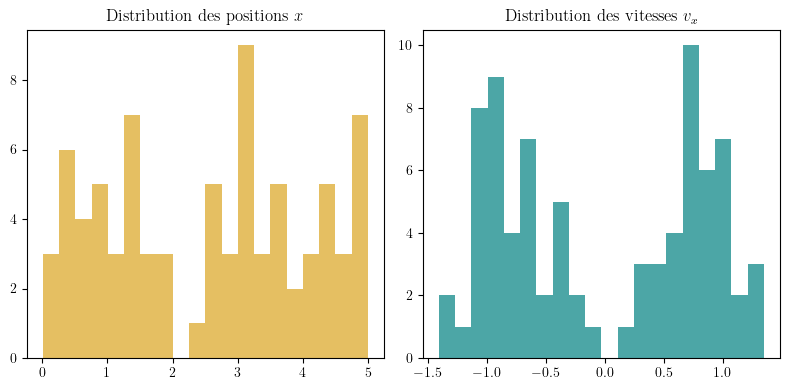

✅ Animation enregistrée : outputs/positions_animation.mp4
Moment d’ordre 2 : 0.7986195060627335


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe ParticleSystem : dynamique et intégration
# ================================================================
class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.05, T=0.12):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T

        # États
        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))

    # --------------------
    # Initialisations
    # --------------------
    def init_positions(self, mode="uniform", centers=None, sigmas=None):
        if mode == "uniform":
            self.positions = np.random.rand(self.num_balls, 2) * self.box_size
        elif mode == "gaussian":
            if centers is None:
                centers = [self.box_size / 2, self.box_size / 2]
            if sigmas is None:
                sigmas = [1, 1]
            self.positions = np.random.normal(centers, sigmas, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            self.positions[:half] = np.random.normal([1.5, 2.5], [0.3, 0.3], (half, 2))
            self.positions[half:] = np.random.normal([3.5, 2.5], [0.3, 0.3], (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de position '{mode}' inconnu.")

    def init_velocities(self, mode="maxwell", sigma=None, means=None):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T) if sigma is None else sigma
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mean1, mean2 = (means or [[-0.8, 0], [0.8, 0]])
            sigma = sigma or [0.3, 0.3]
            self.velocities[:half] = np.random.normal(mean1, sigma, (half, 2))
            self.velocities[half:] = np.random.normal(mean2, sigma, (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de vitesse '{mode}' inconnu.")

    # --------------------
    # Mise à jour temporelle
    # --------------------
    def update(self):
        self.positions += self.velocities * self.dt

        # Bords périodiques
        self.positions %= self.box_size

        # Collisions simples (élastiques)
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)
                if dist < 2 * self.ball_radius:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    impulse = np.dot(dv, direction) * direction
                    self.velocities[i] -= impulse
                    self.velocities[j] += impulse


# ================================================================
# 🔹 2. Classe PhysicalAnalysis : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, system: ParticleSystem):
        self.system = system

    def compute_moments(self, order=2):
        """Retourne les moments d'ordre donné sur les vitesses."""
        v = np.linalg.norm(self.system.velocities, axis=1)
        return np.mean(v ** order)

    def plot_histograms(self, save_dir=None):
        """Histogrammes des positions et vitesses."""
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].hist(self.system.positions[:, 0], bins=20, color="goldenrod", alpha=0.7)
        axes[0].set_title("Distribution des positions $x$")
        axes[1].hist(self.system.velocities[:, 0], bins=20, color="teal", alpha=0.7)
        axes[1].set_title("Distribution des vitesses $v_x$")
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, "histograms.png"), dpi=200)
        plt.show()


# ================================================================
# 🔹 3. Classe AnimationManager : sauvegarde & rendu
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="gif"):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(0, self.system.box_size)
        ax.set_xticks([]); ax.set_yticks([])
        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 85)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)

        file_path = os.path.join(self.output_dir, f"2D_positions_animation.{fmt}")
        if fmt == "gif":
            ani.save(file_path, writer="imagemagick", fps=fps, dpi=200)
        elif fmt == "mp4":
            ani.save(file_path, writer="ffmpeg", fps=fps, dpi=200)

        plt.close(fig)
        print(f"✅ Animation enregistrée : {file_path}")


# ================================================================
# 🔹 Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=80, T=0.1)
    system.init_positions(mode="uniform")
    system.init_velocities(mode="double_gaussian")

    analysis = PhysicalAnalysis(system)
    manager = AnimationManager(system)

    analysis.plot_histograms()
    manager.animate_positions(fmt="mp4")
    print("Moment d’ordre 2 :", analysis.compute_moments(order=2))


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
})

###########################################
# Paramètres
num_balls = 100
ball_radius = 0.09
box_size = 5
dt = 0.05
Nt = 200
Nimages= 200
##------------------------------------------
# Paramètres distribution Maxwell-Boltzmann
T = 0.12   # Température (kb = m = hbar = 1)
##------------------------------------------
flag_print = 0
###########################################

sigma = np.sqrt(T)

# Initialisation des positions et vitesses des balles
positions = np.random.rand(num_balls, 2) * box_size
# velocities = np.random.randn(num_balls, 2)
velocities = np.random.uniform(-1.0,1.0, (num_balls,2))
# velocities =  np.random.normal(0.0, sigma, (num_balls,2))    # Distribution de Maxwell Boltzmann (loi normale)


plt.figure()
plt.hist(np.rot90(velocities)[0],20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()

if flag_print:
    print(positions)
    print(velocities)

# Création de la figure avec une taille fixe
fig, ax = plt.subplots(figsize=(4, 4))  # Taille de la figure : 6 pouces x 6 pouces
ax.set(xlim=(0, box_size), ylim=(0, box_size))
ax.set_xticks([])
ax.set_yticks([])
balls, = ax.plot([], [], 'o', color = "teal", ms=ball_radius*85)

# Ajout de la grille
# ax.grid(True)

# Dessiner la grille manuellement
for i in range(1, int(box_size)):
    ax.plot([i, i], [0, box_size], color='gray', linestyle='--')
    ax.plot([0, box_size], [i, i], color='gray', linestyle='--')

# Fonction d'initialisation de l'animation
def init():
    balls.set_data([], [])
    return balls,

# Fonction de mise à jour de l'animation
def update(frame):
    global velocities

    # Mise à jour des positions des balles en fonction de leurs vitesses
    old_positions = np.copy(positions)
    positions[:] += velocities * dt
    
    # Gestion des rebonds sur les bords de la boîte
    for i in range(num_balls):
        for j in range(2):
            if positions[i, j] < 0:
                positions[i, j] = box_size
            elif positions[i, j] > box_size:
                positions[i, j] = 0

    # Détection et gestion des collisions entre les balles
    for i in range(num_balls):
        for j in range(i + 1, num_balls):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < 2*ball_radius:  # Collision détectée
                # Calcul du vecteur de collision et de l'impulsion
                direction = (positions[j] - positions[i]) / dist
                impulse = np.dot(velocities[j] - velocities[i], direction) * direction
                
                # Mise à jour des vitesses des balles en fonction de la collision
                velocities[i] += impulse
                velocities[j] -= impulse
                
#                 positions[i] = old_positions[i]
#                 positions[j] = old_positions[j]

#     # Mise à jour des positions des balles en fonction de leurs vitesses
#     positions[:] += velocities * dt

    # Mise à jour de la position des balles dans l'animation
    balls.set_data(positions[:, 0], positions[:, 1])
    return balls,

# Création de l'animation
ani = FuncAnimation(fig, update, frames=np.arange(0,Nimages), init_func=init, blit=True, interval = 1000)

# Enregistrement de l'animation en tant que GIF
ani.save('collision_animation_2D_grille.gif', writer='imagemagick', fps = 24, dpi = 200)

# Affichage de l'animation
plt.show()

plt.figure()
plt.hist(np.rot90(velocities)[0], 20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()
